In [52]:
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [53]:
df = pd.read_csv('base.csv')
df.drop(['Unnamed: 0','spotifyID'], axis=1, inplace = True)
df.head()

hit  acousticness  danceability  duration_ms  energy  instrumentalness  \
0    0        0.6520         0.549     153933.0   0.336          0.000000   
1    0        0.0836         0.696     138747.0   0.743          0.197000   
2    0        0.4340         0.652     134573.0   0.838          0.000000   
3    0        0.2950         0.646     147000.0   0.571          0.000009   
4    0        0.9150         0.554     165293.0   0.189          0.000014   

   key  liveness  loudness  mode  speechiness    tempo  time_signature  \
0  0.0     0.134   -11.669   1.0       0.0290  154.958             4.0   
1  1.0     0.119    -6.623   1.0       0.0439  137.276             4.0   
2  0.0     0.328    -6.591   1.0       0.0378  147.219             4.0   
3  6.0     0.319    -6.614   1.0       0.0299   92.919             4.0   
4  4.0     0.132   -14.277   1.0       0.0279  136.714             3.0   

   valence  
0    0.790  
1    0.766  
2    0.965  
3    0.937  
4    0.213

### Análisis simple exploratorio

In [54]:
df.hist();
df.describe()

hit  acousticness  danceability   duration_ms        energy  \
count  21609.000000  21609.000000  21609.000000  2.160900e+04  21609.000000   
mean       0.014438      0.310881      0.590038  2.196476e+05      0.618397   
std        0.119292      0.289821      0.153186  6.537310e+04      0.204569   
min        0.000000      0.000001      0.078200  3.706700e+04      0.016700   
25%        0.000000      0.050900      0.489000  1.718920e+05      0.469000   
50%        0.000000      0.216000      0.599000  2.148270e+05      0.637000   
75%        0.000000      0.546000      0.698000  2.536930e+05      0.785000   
max        1.000000      0.995000      0.986000  1.367093e+06      0.998000   

       instrumentalness           key      liveness      loudness  \
count      21609.000000  21609.000000  21609.000000  21609.000000   
mean           0.038557      5.203758      0.199754     -8.749248   
std            0.149620      3.542464      0.169207      3.640660   
min            0.000000      0.000000      0.013600    -29.110000   
25%            0.000000      2.000000      0.092000    -11.138000   
50%            0.000007      5.000000      0.135000     -8.325000   
75%            0.000684      8.000000      0.262000     -5.952000   
max            0.989000     11.000000      0.993000      2.291000   

               mode   speechiness         tempo  time_signature       valence  
count  21609.000000  21609.000000  21609.000000    21609.000000  21609.000000  
mean       0.742330      0.067957    120.230168        3.922671      0.613233  
std        0.437362      0.074657     28.186875        0.331726      0.236766  
min        0.000000      0.021600     35.393000        1.000000      0.033500  
25%        0.000000      0.032000     99.029000        4.000000      0.431000  
50%        1.000000      0.040400    118.640000        4.000000      0.636000  
75%        1.000000      0.063600    135.959000        4.000000      0.813000  
max        1.000000      0.898000    217.682000        5.000000      0.990000

In [55]:
df.corr()['hit'].apply(abs).sort_values(ascending=False)

hit                 1.000000
duration_ms         0.060838
danceability        0.040893
acousticness        0.038183
liveness            0.024656
speechiness         0.023793
instrumentalness    0.013205
mode                0.012070
time_signature      0.011843
key                 0.007384
loudness            0.007272
tempo               0.006952
valence             0.006113
energy              0.000908
Name: hit, dtype: float64

¿Qué variables están más correlacionadas entre sí y con la variable dependiente?

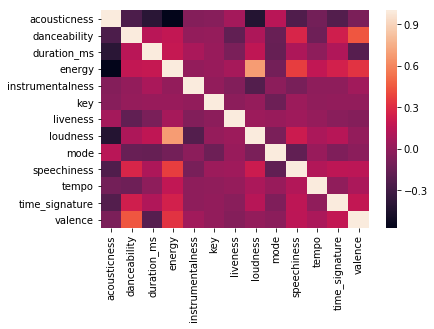

In [56]:
sns.heatmap(df.corr(method = 'spearman').iloc[1:len(df),1:len(df)]);

Tal como se puede observar la correlación entre que sea un HIT con cada característica del tema no es muy representativa.
Quizás a lo sumo se encuentran variables como:

* duration_ms
* danceability
* acousticness

como las más relacionadas una a una con la variable a estimar.

Pero la variable `acousticness` se la nota relacionada con:
* danceability
* duration_ms
* energy
* loudness

Lo cual se podría interpretar que al regresarla con nuestra target puede existir una posible colinealidad.

Armamos la matriz de predictores ($X$) y el target ($y$)

In [57]:
y = df['hit']
X = df.drop(['hit'], axis=1)

Nos preguntaremos primero, ¿qué proporción existe entre el HIT y el no HIT?

In [58]:
df['hit'].value_counts(normalize=True)

0    0.985562
1    0.014438
Name: hit, dtype: float64

Class 0: 21297
Class 1: 312
Proportion: 68.26 : 1


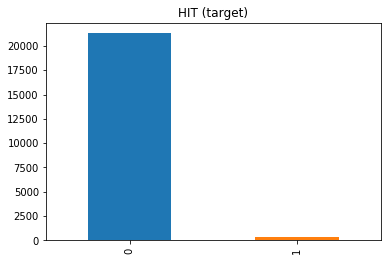

In [59]:
target_count = df['hit'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='HIT (target)');

Tal como se observa, está muy desbalanceada la base.  Con lo cual lo primero que se realizará es balancearla.

### Oversampling

Para aumentar la representación de la clase minoritaria vamos a hacer un oversampling utilizando el algoritmo SMOTE (Synthetic Minority Oversample) del paquete imblearn.

Este algoritmo genera nuevos datos utilizando la técnica de los K vecinos más cercanos.
Para generar un nuevo punto:

1. Se elige un punto al azar de la clase minoritaria y sus K vecinos más cercanos.
2. Se elige al azar uno de esos vecinos.
3. Se calcula el vector entre el punto seleccionado y el vecino seleccionado al azar y se lo multiplica por un número aleatorio entre 0 y 1.
4. El punto aleatorio dentro del vector es el nuevo dato para el oversampling.

Para mostrar de manera gráfica se realizará en base a gráficos 2d un plot que muestre como se realizará el Oversampling, como un antes y un después.

In [60]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Se utilizará PCA para mirar de manera gráfica, dado que se necesita 2 variables para el 2d.

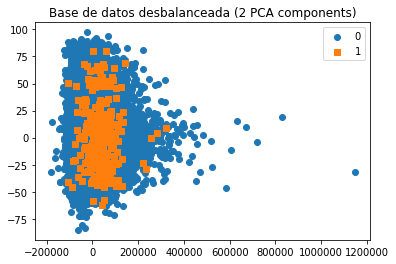

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Base de datos desbalanceada (2 PCA components)')

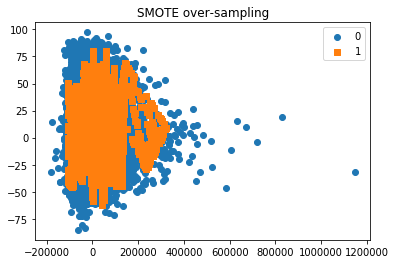

In [62]:
sm = SMOTE(ratio='minority', random_state=1)
X_sm, y_sm = sm.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')